**Logistic Regression Model for Predicting Bad Hydrophone Channels**

The scope of this project is to properly model and train an algorithm that is able to identify bad receivers.

The data contains different receiver statistics which include some instrumentational feedback (capacitance, leakage, sensitivity, etc..) decoded from original SEGD field data. There is also some computed statistics such as, root mean square of (noise) amplitude, standard deviation of RMS, etc.., which would traditionally be used to "pick bad channels") and also some user defined target variable (identified bad receivers).

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.ticker as ticker
from sklearn import preprocessing

List files in directory to use:

In [2]:
import sys, os
print(os.listdir())

['.ipynb_checkpoints', 'Bad_Channels.ipynb', 'decode4ML.flow', '008_P_amp_maps_2265P01.csv', 'decode_listing_features_010_old.csv', 'decode_listing_features_033.csv', 'Bad_Channels_Logistic_Regression.ipynb', 'decode_listing_features_013.csv', 'decode_listing_features_014.csv', 'decode_listing_features_015.csv', 'decode_listing_features_016.csv', 'decode_listing_features_032.csv', '013_P_amp_maps_1378P.csv', 'RMS.png', 'Log_ROC.png', '014_P_amp_maps_1954P.csv', '015_P_amp_maps_1342P.csv', '016_P_amp_maps_1918P.csv', '032_P_amp_maps_1630P.csv', '033_P_amp_maps_1018P.csv', 'Seismic', 'Projects']


Now we import the first set of data, which include have some sequence specific features, including the target feature "BAD_CHAN_FLAG" (binary, 0 good, 1 bad).

In [3]:
stats1=pd.read_csv('decode_listing_features_013.csv')
stats1['SEQ']=1
stats1a=pd.read_csv('decode_listing_features_014.csv')
stats1a['SEQ']=2
stats1b=pd.read_csv('decode_listing_features_015.csv')
stats1b['SEQ']=3
stats1c=pd.read_csv('decode_listing_features_016.csv')
stats1c['SEQ']=4
stats1d=pd.read_csv('decode_listing_features_032.csv')
stats1d['SEQ']=5
stats1e=pd.read_csv('decode_listing_features_033.csv')
stats1e['SEQ']=6
stats1=stats1.append(stats1a)
stats1=stats1.append(stats1b)
stats1=stats1.append(stats1c)
stats1=stats1.append(stats1d)
stats1=stats1.append(stats1e)

/tmp/ipykernel_8776/2940827503.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats1=stats1.append(stats1a)
/tmp/ipykernel_8776/2940827503.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats1=stats1.append(stats1b)
/tmp/ipykernel_8776/2940827503.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats1=stats1.append(stats1c)
/tmp/ipykernel_8776/2940827503.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats1=stats1.append(stats1d)
/tmp/ipykernel_8776/2940827503.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats1=stats1.a

In [4]:
stats1.head()

,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,CHANNEL,DEEP_RMS,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS,SEQ
0,0.0,0.0,0.0,0.0,-563,15.06,NaN,0.0,0.0,0.0,50.39,1
1,0.0,0.0,0.0,0.0,-562,14.71,NaN,0.0,0.0,0.0,50.38,1
2,0.0,0.0,0.0,0.0,-561,15.57,NaN,0.0,0.0,0.0,50.18,1
3,0.0,0.0,0.0,0.0,-560,13.22,NaN,0.0,0.0,0.0,50.27,1
4,0.0,0.0,0.0,0.0,-559,12.68,NaN,0.0,0.0,0.0,50.16,1


Now we import the RMS (noise) amplitude maps that will be used to derive more statistics. These provide an overview of recorded noise on the streamers - both backround and in our case when individual components breakdown and show up as bad channels.

In [5]:
stats2=pd.read_csv('013_P_amp_maps_1378P.csv')
stats2['SEQ']=1
stats2a=pd.read_csv('014_P_amp_maps_1954P.csv')
stats2a['SEQ']=2
stats2b=pd.read_csv('015_P_amp_maps_1342P.csv')
stats2b['SEQ']=3
stats2c=pd.read_csv('016_P_amp_maps_1918P.csv')
stats2c['SEQ']=4
stats2d=pd.read_csv('032_P_amp_maps_1630P.csv')
stats2d['SEQ']=5
stats2e=pd.read_csv('033_P_amp_maps_1018P.csv')
stats2e['SEQ']=6

Due to large file size only run more than one sequence and the following append code block if the computer has enough RAM.

In [6]:
stats2=stats2.append(stats2a)
stats2=stats2.append(stats2b)
stats2=stats2.append(stats2c)
stats2=stats2.append(stats2d)
stats2=stats2.append(stats2e)

/tmp/ipykernel_8776/2355547668.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats2=stats2.append(stats2a)
/tmp/ipykernel_8776/2355547668.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats2=stats2.append(stats2b)
/tmp/ipykernel_8776/2355547668.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats2=stats2.append(stats2c)
/tmp/ipykernel_8776/2355547668.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats2=stats2.append(stats2d)
/tmp/ipykernel_8776/2355547668.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats2=stats2.append

In [7]:
stats2.head()

,SRC_POINT,CHANNEL,WC_RMS,TGT_RMS,DEEP_RMS,WHOLE_RMS,FFID,CABLE,CABTR,SEQ
0,3668,1,7.991693,251.693863,11.629687,1716.062378,1001,1,1,1
1,3668,2,12.171262,250.012650,11.365437,1626.567505,1001,1,2,1
2,3668,3,15.628733,246.957520,11.142121,1506.996704,1001,1,3,1
3,3668,4,8.051885,245.593567,11.637615,1445.203003,1001,1,4,1
4,3668,5,7.950213,239.795166,11.967460,1344.174316,1001,1,5,1


Get standard deviation of root mean squared values, grouped by sequence and receiver number.

In [8]:
std_=stats2.groupby(['SEQ','CHANNEL'])['DEEP_RMS'].agg(np.std)

In [9]:
std_=pd.DataFrame(std_)

In [10]:
std_.sort_values(['SEQ','CHANNEL'],inplace=True)
stats1.sort_values(['SEQ','CHANNEL'],inplace=True)

In [11]:
std_.reset_index(inplace=True)
len(std_)

40608

In [12]:
len(stats1)

4528800

In [13]:
std_.head()

,SEQ,CHANNEL,DEEP_RMS
0,1,1,3.549774
1,1,2,4.539793
2,1,3,3.040472
3,1,4,2.383910
4,1,5,2.365788


Merge the two dataframes.

In [14]:
df1=pd.merge(std_,stats1 , how='left', left_on=['SEQ','CHANNEL'], right_on=['SEQ','CHANNEL'])
df2=df1.copy()

In [15]:
df2.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
1,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
2,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
3,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
4,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
5,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
6,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
7,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
8,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
9,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39


Plot the Root Mean Square (RMS) of (noise) Amplitudes

In [16]:
a=stats2['DEEP_RMS']

In [17]:
b=a.to_list()

Re-shape the list for plotting (y = number of channels; x = number of SP for six sequences concatenated). i.e. 12 * 564 channels; (3950 - 1001) * 6

In [18]:
c=np.reshape(b,(-1,6768))
c=np.transpose(c)

A little clipping of the value to 100 for colour scaling.

In [19]:
c=np.clip(c,0,30)

In [20]:
%matplotlib inline

/tmp/ipykernel_8776/2966049906.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


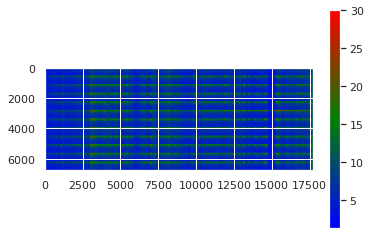

In [21]:
import matplotlib.colors as colly

cmap1= colly.LinearSegmentedColormap.from_list("" , ['blue','green','red'])

im=plt.imshow(c, cmap=cmap1)
plt.colorbar(im)
plt.rcParams["figure.figsize"] = (70,20)
plt.savefig('RMS.png')

plt.show()

**Now for the modelling part...**

In [22]:
df1.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
1,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
2,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
3,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
4,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
5,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
6,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
7,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
8,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39
9,1,1,3.549774,0.0,0.0,0.0,273.262848,15.06,1.0,0.0,5.0,0.0,50.39


Drop one by one the features we do not need...

In [23]:
df1=df1.drop('CAP_CUT_ERR',1)
df1=df1.drop('CAP_ERR',1)
df1=df1.drop('LEAK_ERR',1)
df1=df1.drop('SENS',1)
df1=df1.drop('MARG_CHAN_FLAG',1)

/tmp/ipykernel_8776/1774694302.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('CAP_CUT_ERR',1)
/tmp/ipykernel_8776/1774694302.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('CAP_ERR',1)
/tmp/ipykernel_8776/1774694302.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('LEAK_ERR',1)
/tmp/ipykernel_8776/1774694302.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('SENS',1)
/tmp/ipykernel_8776/1774694302.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('MARG_CHAN_FLAG',1)


In [24]:
df1.head()

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_VAL
0,1,1,3.549774,0.0,273.262848,15.06,1.0,5.0
1,1,1,3.549774,0.0,273.262848,15.06,1.0,5.0
2,1,1,3.549774,0.0,273.262848,15.06,1.0,5.0
3,1,1,3.549774,0.0,273.262848,15.06,1.0,5.0
4,1,1,3.549774,0.0,273.262848,15.06,1.0,5.0


In [25]:
pd.to_numeric(df1['BAD_CHAN_FLAG'])
y=pd.DataFrame(df1['BAD_CHAN_FLAG'])
X=df1.drop(['BAD_CHAN_FLAG'],1)

/tmp/ipykernel_8776/1240260745.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df1.drop(['BAD_CHAN_FLAG'],1)


In [26]:
yy=y.values.tolist()

In [27]:
X2=X.copy()
X2=X2.drop(['CHANNEL','SEQ'],1)

/tmp/ipykernel_8776/447026479.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2=X2.drop(['CHANNEL','SEQ'],1)


In [28]:
# Calculate the correlation values
feature_cols = X2.columns
corr_values = X2[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

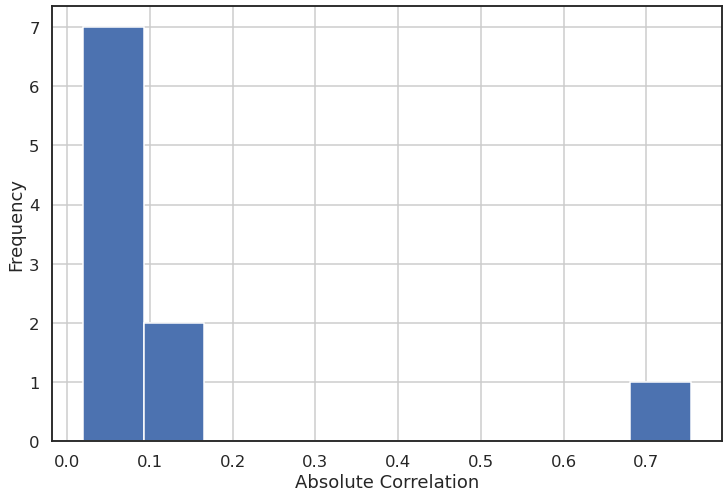

In [29]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=10, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [30]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.2')

,feature1,feature2,correlation,abs_correlation
1,DEEP_RMS_x,DEEP_RMS_y,0.754534,0.754534


**Logistic Regression**

In [31]:
XX=X2.values.tolist()

In [32]:
XX[0:5]

[[3.549773889755418, 273.262848, 15.06, 1.0, 5.0],
 [3.549773889755418, 273.262848, 15.06, 1.0, 5.0],
 [3.549773889755418, 273.262848, 15.06, 1.0, 5.0],
 [3.549773889755418, 273.262848, 15.06, 1.0, 5.0],
 [3.549773889755418, 273.262848, 15.06, 1.0, 5.0]]

We use a standard scalar to normalise the dataset.

In [33]:
XX=preprocessing.StandardScaler().fit(XX).transform(XX)

In [34]:
XX[0:5]

array([[1.23619462, 0.70522256, 2.58304079, 3.72927459, 0.07318894],
       [1.23619462, 0.70522256, 2.58304079, 3.72927459, 0.07318894],
       [1.23619462, 0.70522256, 2.58304079, 3.72927459, 0.07318894],
       [1.23619462, 0.70522256, 2.58304079, 3.72927459, 0.07318894],
       [1.23619462, 0.70522256, 2.58304079, 3.72927459, 0.07318894]])

Test the logistic regression on the whole dataset.

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(yy,XX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.691477
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: -38.743     
Dependent Variable: y                AIC:              6233661.7059
Date:               2022-08-26 03:18 BIC:              6233728.3122
No. Observations:   4507488          Log-Likelihood:   -3.1168e+06 
Df Model:           4                LL-Null:          -78425.     
Df Residuals:       4507483          LLR p-value:      1.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     5.0000                                         
----------------------------------------------------------------------
        Coef.     Std.Err.       z        P>|z|      [0.025     0.975]
----------------------------------------------------------------------
x1      0.0567      0.0019     30.5929    0.0000     0.0531     0.0604
x2     -0.1193      0.0013   

We now split the data to see how it perform with the train/test.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.5, random_state=0)

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/corproc/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [38]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


Now we examine the Confusion Matrix.

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2247930     215]
 [   3011    2588]]


We now examine some key metrics to see if the model acts properly.

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2248145
         1.0       0.92      0.46      0.62      5599

    accuracy                           1.00   2253744
   macro avg       0.96      0.73      0.81   2253744
weighted avg       1.00      1.00      1.00   2253744



Now we look at the Receiver Operating Characteristic (ROC) curve.

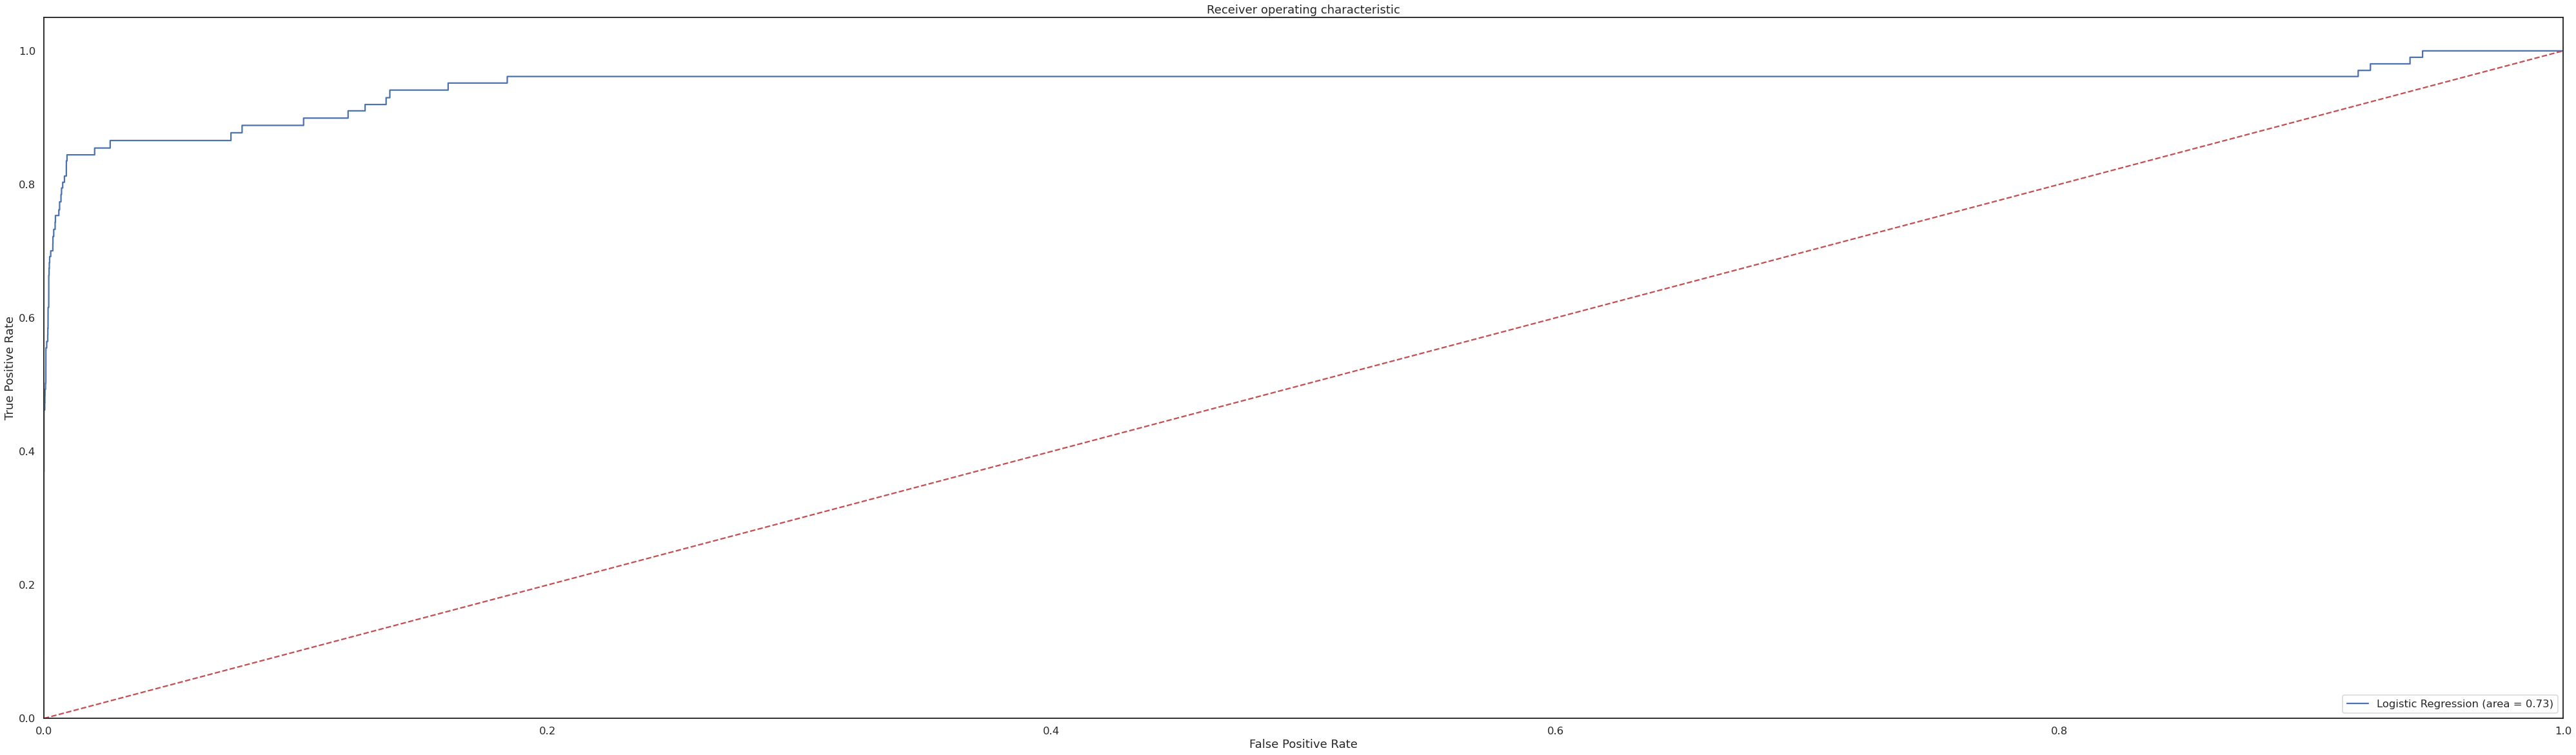

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC.png')
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

Attempting to get the sequence and channel back to a dataframe.

In [42]:
fd=pd.DataFrame(y_pred)
fd2=pd.DataFrame(y_test)

In [43]:
fd2.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [44]:
FD2=fd2.reset_index()
FD2.set_axis(['index','FLAG_ORIG'],axis=1,inplace=True)

In [45]:
merge=FD2.merge(fd,left_index=True, right_index=True)
merge.set_axis(['index','FLAG_ORIG','PREDICT'],axis=1,inplace=True)

In [46]:
merge.head()

,index,FLAG_ORIG,PREDICT
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0


We create a header to spot the different predictions.

In [47]:
merge['DIFF']=merge['FLAG_ORIG']-merge['PREDICT']

In [48]:
finder=merge['DIFF']!=0
finder

0          False
1          False
2          False
3          False
4          False
           ...  
2253739    False
2253740    False
2253741    False
2253742    False
2253743    False
Name: DIFF, Length: 2253744, dtype: bool

We check what has been predicted different from the test data.

In [49]:
for i,x in merge.iterrows():
    if x['DIFF']!=0:
        print(x)

index        21.0
FLAG_ORIG     1.0
PREDICT       0.0
DIFF          1.0
Name: 21, dtype: float64
index        428.0
FLAG_ORIG      1.0
PREDICT        0.0
DIFF           1.0
Name: 428, dtype: float64
index        1569.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 1569, dtype: float64
index        2252.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 2252, dtype: float64
index        2704.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 2704, dtype: float64
index        3239.0
FLAG_ORIG       0.0
PREDICT         1.0
DIFF           -1.0
Name: 3239, dtype: float64
index        3872.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 3872, dtype: float64
index        3963.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 3963, dtype: float64
index        3981.0
FLAG_ORIG       1.0
PREDICT         0.0
DIFF            1.0
Name: 3981, dtype: float64
index        4141.0
FLAG_ORIG       1.0
PREDICT     

index        53413.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 53413, dtype: float64
index        53648.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 53648, dtype: float64
index        53774.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 53774, dtype: float64
index        54203.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 54203, dtype: float64
index        56156.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 56156, dtype: float64
index        56623.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 56623, dtype: float64
index        57438.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 57438, dtype: float64
index        58239.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 58239, dtype: float64
index        60183.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 60183, dtype: 

index        109470.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 109470, dtype: float64
index        109589.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 109589, dtype: float64
index        110308.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 110308, dtype: float64
index        110857.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 110857, dtype: float64
index        111742.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 111742, dtype: float64
index        111903.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 111903, dtype: float64
index        112007.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 112007, dtype: float64
index        112241.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 112241, dtype: float64
index        112664.0
FLAG_ORIG         1.0
PREDICT           0.

index        162617.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 162617, dtype: float64
index        162642.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 162642, dtype: float64
index        163853.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 163853, dtype: float64
index        163984.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 163984, dtype: float64
index        164155.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 164155, dtype: float64
index        164259.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 164259, dtype: float64
index        165387.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 165387, dtype: float64
index        165557.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 165557, dtype: float64
index        165921.0
FLAG_ORIG         0.0
PREDICT           1.

index        209965.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 209965, dtype: float64
index        210596.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 210596, dtype: float64
index        213292.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 213292, dtype: float64
index        213586.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 213586, dtype: float64
index        214511.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 214511, dtype: float64
index        214901.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 214901, dtype: float64
index        215724.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 215724, dtype: float64
index        216056.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 216056, dtype: float64
index        217082.0
FLAG_ORIG         1.0
PREDICT           0.

index        259111.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 259111, dtype: float64
index        259150.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 259150, dtype: float64
index        259915.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 259915, dtype: float64
index        260138.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 260138, dtype: float64
index        260743.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 260743, dtype: float64
index        261784.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 261784, dtype: float64
index        262389.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 262389, dtype: float64
index        262408.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 262408, dtype: float64
index        262702.0
FLAG_ORIG         1.0
PREDICT           0.

index        311509.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 311509, dtype: float64
index        312553.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 312553, dtype: float64
index        313708.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 313708, dtype: float64
index        315030.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 315030, dtype: float64
index        315848.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 315848, dtype: float64
index        316205.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 316205, dtype: float64
index        316720.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 316720, dtype: float64
index        317211.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 317211, dtype: float64
index        318399.0
FLAG_ORIG         1.0
PREDICT           0.

index        367728.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 367728, dtype: float64
index        368919.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 368919, dtype: float64
index        369966.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 369966, dtype: float64
index        371368.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 371368, dtype: float64
index        371775.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 371775, dtype: float64
index        373047.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 373047, dtype: float64
index        373072.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 373072, dtype: float64
index        374654.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 374654, dtype: float64
index        376406.0
FLAG_ORIG         1.0
PREDICT           0.

index        428200.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 428200, dtype: float64
index        428483.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 428483, dtype: float64
index        431073.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 431073, dtype: float64
index        431320.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 431320, dtype: float64
index        432084.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 432084, dtype: float64
index        432505.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 432505, dtype: float64
index        433015.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 433015, dtype: float64
index        433087.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 433087, dtype: float64
index        434422.0
FLAG_ORIG         1.0
PREDICT           0.

index        479165.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 479165, dtype: float64
index        479529.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 479529, dtype: float64
index        479744.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 479744, dtype: float64
index        481047.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 481047, dtype: float64
index        481458.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 481458, dtype: float64
index        483421.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 483421, dtype: float64
index        483907.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 483907, dtype: float64
index        484260.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 484260, dtype: float64
index        485383.0
FLAG_ORIG         1.0
PREDICT           0.

index        535385.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 535385, dtype: float64
index        536196.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 536196, dtype: float64
index        536221.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 536221, dtype: float64
index        536424.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 536424, dtype: float64
index        536834.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 536834, dtype: float64
index        537420.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 537420, dtype: float64
index        538258.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 538258, dtype: float64
index        539079.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 539079, dtype: float64
index        540244.0
FLAG_ORIG         1.0
PREDICT           0.

index        583082.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 583082, dtype: float64
index        583890.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 583890, dtype: float64
index        584658.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 584658, dtype: float64
index        584852.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 584852, dtype: float64
index        585279.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 585279, dtype: float64
index        588797.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 588797, dtype: float64
index        590830.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 590830, dtype: float64
index        591607.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 591607, dtype: float64
index        591788.0
FLAG_ORIG         1.0
PREDICT           0.

index        655393.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 655393, dtype: float64
index        655989.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 655989, dtype: float64
index        656932.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 656932, dtype: float64
index        657204.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 657204, dtype: float64
index        658375.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 658375, dtype: float64
index        659244.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 659244, dtype: float64
index        659411.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 659411, dtype: float64
index        659824.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 659824, dtype: float64
index        660123.0
FLAG_ORIG         1.0
PREDICT           0.

index        701126.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 701126, dtype: float64
index        701936.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 701936, dtype: float64
index        702812.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 702812, dtype: float64
index        702841.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 702841, dtype: float64
index        703687.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 703687, dtype: float64
index        704503.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 704503, dtype: float64
index        705441.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 705441, dtype: float64
index        705693.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 705693, dtype: float64
index        705933.0
FLAG_ORIG         1.0
PREDICT           0.

index        750598.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 750598, dtype: float64
index        750667.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 750667, dtype: float64
index        750790.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 750790, dtype: float64
index        754139.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 754139, dtype: float64
index        754290.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 754290, dtype: float64
index        754644.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 754644, dtype: float64
index        756062.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 756062, dtype: float64
index        756384.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 756384, dtype: float64
index        757861.0
FLAG_ORIG         1.0
PREDICT           0.

index        805639.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 805639, dtype: float64
index        807325.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 807325, dtype: float64
index        807577.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 807577, dtype: float64
index        808458.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 808458, dtype: float64
index        809090.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 809090, dtype: float64
index        809103.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 809103, dtype: float64
index        809106.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 809106, dtype: float64
index        809339.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 809339, dtype: float64
index        812031.0
FLAG_ORIG         1.0
PREDICT           0.

index        867612.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 867612, dtype: float64
index        867805.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 867805, dtype: float64
index        868045.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 868045, dtype: float64
index        872369.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 872369, dtype: float64
index        873896.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 873896, dtype: float64
index        874569.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 874569, dtype: float64
index        875900.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 875900, dtype: float64
index        876966.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 876966, dtype: float64
index        877602.0
FLAG_ORIG         1.0
PREDICT           0.

index        929470.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 929470, dtype: float64
index        930526.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 930526, dtype: float64
index        932664.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 932664, dtype: float64
index        934373.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 934373, dtype: float64
index        935906.0
FLAG_ORIG         0.0
PREDICT           1.0
DIFF             -1.0
Name: 935906, dtype: float64
index        936417.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 936417, dtype: float64
index        937867.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 937867, dtype: float64
index        937992.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 937992, dtype: float64
index        938535.0
FLAG_ORIG         1.0
PREDICT           0.

index        980202.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 980202, dtype: float64
index        982151.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 982151, dtype: float64
index        982581.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 982581, dtype: float64
index        982902.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 982902, dtype: float64
index        983712.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 983712, dtype: float64
index        983854.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 983854, dtype: float64
index        985380.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 985380, dtype: float64
index        985435.0
FLAG_ORIG         1.0
PREDICT           0.0
DIFF              1.0
Name: 985435, dtype: float64
index        985621.0
FLAG_ORIG         1.0
PREDICT           0.

index        1027985.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1027985, dtype: float64
index        1028654.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1028654, dtype: float64
index        1028748.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1028748, dtype: float64
index        1029108.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1029108, dtype: float64
index        1031022.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1031022, dtype: float64
index        1032336.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1032336, dtype: float64
index        1033517.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1033517, dtype: float64
index        1033539.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1033539, dtype: float64
index        1034595.0
F

index        1074185.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1074185, dtype: float64
index        1075554.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1075554, dtype: float64
index        1076542.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1076542, dtype: float64
index        1077550.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1077550, dtype: float64
index        1077745.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1077745, dtype: float64
index        1078286.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1078286, dtype: float64
index        1078611.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1078611, dtype: float64
index        1079900.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1079900, dtype: float64
index        1080149.0
F

index        1122880.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1122880, dtype: float64
index        1123172.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1123172, dtype: float64
index        1123278.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1123278, dtype: float64
index        1123786.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1123786, dtype: float64
index        1123825.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1123825, dtype: float64
index        1124130.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1124130, dtype: float64
index        1126397.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1126397, dtype: float64
index        1126629.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1126629, dtype: float64
index        1126793.0
F

index        1176696.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1176696, dtype: float64
index        1177061.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1177061, dtype: float64
index        1177753.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1177753, dtype: float64
index        1177826.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1177826, dtype: float64
index        1179115.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1179115, dtype: float64
index        1180322.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1180322, dtype: float64
index        1180682.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1180682, dtype: float64
index        1181003.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1181003, dtype: float64
index        1181319.0
F

index        1237444.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1237444, dtype: float64
index        1237621.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1237621, dtype: float64
index        1237724.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1237724, dtype: float64
index        1238495.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1238495, dtype: float64
index        1238696.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1238696, dtype: float64
index        1240457.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1240457, dtype: float64
index        1241559.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1241559, dtype: float64
index        1242835.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1242835, dtype: float64
index        1242965.0
F

index        1292228.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1292228, dtype: float64
index        1292739.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1292739, dtype: float64
index        1293315.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1293315, dtype: float64
index        1293987.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1293987, dtype: float64
index        1294027.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1294027, dtype: float64
index        1296024.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1296024, dtype: float64
index        1296227.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1296227, dtype: float64
index        1296305.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1296305, dtype: float64
index        1296308.0
F

index        1348949.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1348949, dtype: float64
index        1349604.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1349604, dtype: float64
index        1350074.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1350074, dtype: float64
index        1351189.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1351189, dtype: float64
index        1351483.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1351483, dtype: float64
index        1351900.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1351900, dtype: float64
index        1352045.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1352045, dtype: float64
index        1352439.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1352439, dtype: float64
index        1352606.0
F

index        1398777.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1398777, dtype: float64
index        1400103.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1400103, dtype: float64
index        1400265.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1400265, dtype: float64
index        1401865.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1401865, dtype: float64
index        1402466.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1402466, dtype: float64
index        1403597.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1403597, dtype: float64
index        1404117.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1404117, dtype: float64
index        1405057.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1405057, dtype: float64
index        1406164.0
F

index        1444169.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1444169, dtype: float64
index        1444476.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1444476, dtype: float64
index        1445499.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1445499, dtype: float64
index        1445786.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1445786, dtype: float64
index        1446342.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1446342, dtype: float64
index        1447647.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1447647, dtype: float64
index        1448310.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1448310, dtype: float64
index        1449122.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1449122, dtype: float64
index        1449535.0
F

index        1494378.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1494378, dtype: float64
index        1494389.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1494389, dtype: float64
index        1494589.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1494589, dtype: float64
index        1495160.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1495160, dtype: float64
index        1495318.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1495318, dtype: float64
index        1495381.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1495381, dtype: float64
index        1495560.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1495560, dtype: float64
index        1496155.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1496155, dtype: float64
index        1496399.0
F

index        1543586.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1543586, dtype: float64
index        1543636.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1543636, dtype: float64
index        1544100.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1544100, dtype: float64
index        1544888.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1544888, dtype: float64
index        1544948.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1544948, dtype: float64
index        1545025.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1545025, dtype: float64
index        1547591.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1547591, dtype: float64
index        1548940.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1548940, dtype: float64
index        1549283.0
F

index        1603414.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1603414, dtype: float64
index        1603792.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1603792, dtype: float64
index        1604857.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1604857, dtype: float64
index        1604932.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1604932, dtype: float64
index        1604959.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1604959, dtype: float64
index        1606058.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1606058, dtype: float64
index        1607532.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1607532, dtype: float64
index        1607571.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1607571, dtype: float64
index        1607955.0
F

index        1654886.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1654886, dtype: float64
index        1655052.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1655052, dtype: float64
index        1656240.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1656240, dtype: float64
index        1656375.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1656375, dtype: float64
index        1657575.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1657575, dtype: float64
index        1658121.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1658121, dtype: float64
index        1658345.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1658345, dtype: float64
index        1658845.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1658845, dtype: float64
index        1658946.0
F

index        1695978.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1695978, dtype: float64
index        1695991.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1695991, dtype: float64
index        1695997.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1695997, dtype: float64
index        1696361.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1696361, dtype: float64
index        1696727.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1696727, dtype: float64
index        1698251.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1698251, dtype: float64
index        1699468.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1699468, dtype: float64
index        1700991.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1700991, dtype: float64
index        1703936.0
F

index        1744172.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1744172, dtype: float64
index        1746356.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1746356, dtype: float64
index        1746552.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1746552, dtype: float64
index        1746923.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1746923, dtype: float64
index        1746950.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1746950, dtype: float64
index        1747004.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1747004, dtype: float64
index        1748642.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1748642, dtype: float64
index        1750472.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1750472, dtype: float64
index        1750667.0
F

index        1805823.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1805823, dtype: float64
index        1806576.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1806576, dtype: float64
index        1806637.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1806637, dtype: float64
index        1807201.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1807201, dtype: float64
index        1807446.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1807446, dtype: float64
index        1809382.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1809382, dtype: float64
index        1810390.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1810390, dtype: float64
index        1812539.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1812539, dtype: float64
index        1812735.0
F

index        1861123.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1861123, dtype: float64
index        1861680.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1861680, dtype: float64
index        1862218.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1862218, dtype: float64
index        1862331.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1862331, dtype: float64
index        1862594.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1862594, dtype: float64
index        1863669.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1863669, dtype: float64
index        1863684.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1863684, dtype: float64
index        1863856.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1863856, dtype: float64
index        1863915.0
F

index        1907132.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1907132, dtype: float64
index        1907572.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1907572, dtype: float64
index        1908226.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 1908226, dtype: float64
index        1909080.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1909080, dtype: float64
index        1909109.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1909109, dtype: float64
index        1910415.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1910415, dtype: float64
index        1911450.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1911450, dtype: float64
index        1911844.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1911844, dtype: float64
index        1912960.0
F

index        1960043.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1960043, dtype: float64
index        1963339.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1963339, dtype: float64
index        1963424.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1963424, dtype: float64
index        1963823.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1963823, dtype: float64
index        1964010.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1964010, dtype: float64
index        1964231.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1964231, dtype: float64
index        1964384.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1964384, dtype: float64
index        1964469.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 1964469, dtype: float64
index        1965128.0
F

index        2009130.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2009130, dtype: float64
index        2009479.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2009479, dtype: float64
index        2010056.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 2010056, dtype: float64
index        2011456.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2011456, dtype: float64
index        2011988.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2011988, dtype: float64
index        2012601.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2012601, dtype: float64
index        2012663.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2012663, dtype: float64
index        2012713.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2012713, dtype: float64
index        2013382.0
F

index        2055884.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2055884, dtype: float64
index        2058944.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2058944, dtype: float64
index        2059512.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2059512, dtype: float64
index        2059686.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2059686, dtype: float64
index        2060509.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 2060509, dtype: float64
index        2061081.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 2061081, dtype: float64
index        2061272.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2061272, dtype: float64
index        2061501.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2061501, dtype: float64
index        2061815.0
F

index        2103479.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2103479, dtype: float64
index        2105300.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2105300, dtype: float64
index        2106190.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2106190, dtype: float64
index        2106554.0
FLAG_ORIG          0.0
PREDICT            1.0
DIFF              -1.0
Name: 2106554, dtype: float64
index        2106648.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2106648, dtype: float64
index        2107182.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2107182, dtype: float64
index        2107446.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2107446, dtype: float64
index        2107938.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2107938, dtype: float64
index        2109039.0
F

index        2150948.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2150948, dtype: float64
index        2150988.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2150988, dtype: float64
index        2151388.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2151388, dtype: float64
index        2152338.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2152338, dtype: float64
index        2152481.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2152481, dtype: float64
index        2154458.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2154458, dtype: float64
index        2156231.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2156231, dtype: float64
index        2157171.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2157171, dtype: float64
index        2157496.0
F

index        2207621.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2207621, dtype: float64
index        2209188.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2209188, dtype: float64
index        2210980.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2210980, dtype: float64
index        2211707.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2211707, dtype: float64
index        2214040.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2214040, dtype: float64
index        2214241.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2214241, dtype: float64
index        2215250.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2215250, dtype: float64
index        2215761.0
FLAG_ORIG          1.0
PREDICT            0.0
DIFF               1.0
Name: 2215761, dtype: float64
index        2215812.0
F

In [50]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df1, df1, test_size=0.5, random_state=0)

In [51]:
FD3=y1_test.reset_index()
newtest=pd.merge(FD3,merge)

In [52]:
newtest.head()

,index,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_VAL,FLAG_ORIG,PREDICT,DIFF
0,418051,1,3767,0.766647,0.0,265.553741,4.58,0.0,5.0,0.0,0.0,0.0
1,999257,2,2235,0.898606,0.0,272.793030,5.86,0.0,5.0,0.0,0.0,0.0
2,502372,1,4526,2.477520,0.0,273.365234,10.79,0.0,5.0,0.0,0.0,0.0
3,1163276,2,3712,1.024132,0.0,267.292175,6.50,0.0,5.0,0.0,0.0,0.0
4,144565,1,1303,1.096237,0.0,269.351135,5.71,0.0,5.0,0.0,0.0,0.0


In [53]:
for i,x in newtest.iterrows():
    if x['PREDICT']>x['BAD_CHAN_FLAG']:
        print(x)

index            1.077350e+06
SEQ              2.000000e+00
CHANNEL          2.938000e+03
DEEP_RMS_x       2.702978e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.651824e+02
DEEP_RMS_y       1.040000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1050, dtype: float64
index            1.850932e+06
SEQ              3.000000e+00
CHANNEL          3.140000e+03
DEEP_RMS_x       1.163191e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.732641e+02
DEEP_RMS_y       6.280000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1268, dtype: float64
index            1.896624e+06
SEQ              3.000000e+00
CHANNEL          3.551000e+03
DEEP_RMS_x       1.709701e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.714930e+02
DEEP_RMS_y       8.010000e+00
DEVICE          

index            2.214324e+06
SEQ              3.000000e+00
CHANNEL          6.413000e+03
DEEP_RMS_x       1.417802e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.711962e+02
DEEP_RMS_y       7.230000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 19735, dtype: float64
index            1.707101e+06
SEQ              3.000000e+00
CHANNEL          1.844000e+03
DEEP_RMS_x       1.900473e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.706634e+02
DEEP_RMS_y       8.160000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 20248, dtype: float64
index            348892.000000
SEQ                   1.000000
CHANNEL            3144.000000
DEEP_RMS_x            1.164518
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.628693
DEEP_RMS_y            5.700000
DEVICE 

index            560514.000000
SEQ                   1.000000
CHANNEL            5050.000000
DEEP_RMS_x            0.733844
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.482758
DEEP_RMS_y            4.080000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 39617, dtype: float64
index            2.232595e+06
SEQ              3.000000e+00
CHANNEL          6.578000e+03
DEEP_RMS_x       1.076975e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.676151e+02
DEEP_RMS_y       6.090000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 41330, dtype: float64
index            1.282969e+06
SEQ              2.000000e+00
CHANNEL          4.791000e+03
DEEP_RMS_x       1.180397e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.693026e+02
DEEP_RMS_y       6.980000e+00
DE

index            1.421331e+06
SEQ              2.000000e+00
CHANNEL          6.037000e+03
DEEP_RMS_x       1.217859e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.700764e+02
DEEP_RMS_y       7.320000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 62096, dtype: float64
index            2.049053e+06
SEQ              3.000000e+00
CHANNEL          4.924000e+03
DEEP_RMS_x       9.659698e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.694358e+02
DEEP_RMS_y       5.810000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 63354, dtype: float64
index            1.312493e+06
SEQ              2.000000e+00
CHANNEL          5.057000e+03
DEEP_RMS_x       9.735353e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.706311e+02
DEEP_RMS_y       5.610000e+00
DEVICE        

index            1.336044e+06
SEQ              2.000000e+00
CHANNEL          5.269000e+03
DEEP_RMS_x       1.590195e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.698603e+02
DEEP_RMS_y       8.100000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 84391, dtype: float64
index            622076.000000
SEQ                   1.000000
CHANNEL            5605.000000
DEEP_RMS_x            0.798242
BAD_CHAN_FLAG         0.000000
CAP_VAL             263.467957
DEEP_RMS_y            4.250000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 84737, dtype: float64
index            1.525907e+06
SEQ              3.000000e+00
CHANNEL          2.110000e+02
DEEP_RMS_x       1.474248e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.657237e+02
DEEP_RMS_y       7.190000e+00
DE

index            418661.000000
SEQ                   1.000000
CHANNEL            3772.000000
DEEP_RMS_x            0.810483
BAD_CHAN_FLAG         0.000000
CAP_VAL             276.042633
DEEP_RMS_y            4.690000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 104564, dtype: float64
index            974165.000000
SEQ                   2.000000
CHANNEL            2009.000000
DEEP_RMS_x            0.941711
BAD_CHAN_FLAG         0.000000
CAP_VAL             267.573303
DEEP_RMS_y            6.680000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 104740, dtype: float64
index            2.075903e+06
SEQ              3.000000e+00
CHANNEL          5.166000e+03
DEEP_RMS_x       3.101386e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.741044e+02
DEEP_RMS_y       1

index            1.771523e+06
SEQ              3.000000e+00
CHANNEL          2.424000e+03
DEEP_RMS_x       1.807366e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.698341e+02
DEEP_RMS_y       7.960000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 125041, dtype: float64
index            248048.000000
SEQ                   1.000000
CHANNEL            2235.000000
DEEP_RMS_x            0.861187
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.793030
DEEP_RMS_y            4.490000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 125187, dtype: float64
index            111317.000000
SEQ                   1.000000
CHANNEL            1003.000000
DEEP_RMS_x            0.681689
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.643463
DEEP_RMS_y            4.

index            1.970491e+06
SEQ              3.000000e+00
CHANNEL          4.217000e+03
DEEP_RMS_x       1.260513e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.623751e+02
DEEP_RMS_y       6.290000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 153685, dtype: float64
index            766847.000000
SEQ                   2.000000
CHANNEL             141.000000
DEEP_RMS_x            1.776887
BAD_CHAN_FLAG         0.000000
CAP_VAL             267.367249
DEEP_RMS_y            9.470000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 154042, dtype: float64
index            1.058360e+06
SEQ              2.000000e+00
CHANNEL          2.767000e+03
DEEP_RMS_x       9.279230e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.679653e+02
DEEP_RMS_y       5.270000e+00


index            558581.000000
SEQ                   1.000000
CHANNEL            5033.000000
DEEP_RMS_x            0.760421
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.426636
DEEP_RMS_y            4.200000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 176080, dtype: float64
index            1.094858e+06
SEQ              2.000000e+00
CHANNEL          3.096000e+03
DEEP_RMS_x       1.116107e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.710537e+02
DEEP_RMS_y       7.150000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 177550, dtype: float64
index            1.393634e+06
SEQ              2.000000e+00
CHANNEL          5.788000e+03
DEEP_RMS_x       2.415417e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.691686e+02
DEEP_RMS_y       9.230000e+00


index            1.225022e+06
SEQ              2.000000e+00
CHANNEL          4.269000e+03
DEEP_RMS_x       1.123565e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.704200e+02
DEEP_RMS_y       6.560000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 189335, dtype: float64
index            407688.000000
SEQ                   1.000000
CHANNEL            3673.000000
DEEP_RMS_x            0.890615
BAD_CHAN_FLAG         0.000000
CAP_VAL             267.522156
DEEP_RMS_y            5.030000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 189640, dtype: float64
index            409554.000000
SEQ                   1.000000
CHANNEL            3690.000000
DEEP_RMS_x            0.826656
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.985199
DEEP_RMS_y            4.

index            1.484106e+06
SEQ              2.000000e+00
CHANNEL          6.603000e+03
DEEP_RMS_x       9.448395e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.678397e+02
DEEP_RMS_y       6.110000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 210800, dtype: float64
index            932219.000000
SEQ                   2.000000
CHANNEL            1631.000000
DEEP_RMS_x            0.871074
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.993164
DEEP_RMS_y            5.180000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 210894, dtype: float64
index            385858.000000
SEQ                   1.000000
CHANNEL            3477.000000
DEEP_RMS_x            1.633428
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.947052
DEEP_RMS_y            7.

index            83677.000000
SEQ                  1.000000
CHANNEL            754.000000
DEEP_RMS_x           1.043484
BAD_CHAN_FLAG        0.000000
CAP_VAL            268.300201
DEEP_RMS_y           5.480000
DEVICE               0.000000
LEAK_VAL             5.000000
FLAG_ORIG            1.000000
PREDICT              1.000000
DIFF                 0.000000
Name: 231301, dtype: float64
index            913537.000000
SEQ                   2.000000
CHANNEL            1463.000000
DEEP_RMS_x            0.916719
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.636230
DEEP_RMS_y            6.340000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 232729, dtype: float64
index            575518.000000
SEQ                   1.000000
CHANNEL            5185.000000
DEEP_RMS_x            1.709583
BAD_CHAN_FLAG         0.000000
CAP_VAL             273.932617
DEEP_RMS_y            8.

index            746266.000000
SEQ                   1.000000
CHANNEL            6724.000000
DEEP_RMS_x            0.719508
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.156464
DEEP_RMS_y            4.180000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 258671, dtype: float64
index            2.135363e+06
SEQ              3.000000e+00
CHANNEL          5.702000e+03
DEEP_RMS_x       3.537355e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.740152e+02
DEEP_RMS_y       1.207000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 262666, dtype: float64
index            884591.000000
SEQ                   2.000000
CHANNEL            1202.000000
DEEP_RMS_x            3.208297
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.784058
DEEP_RMS_y           12.

index            1.785770e+06
SEQ              3.000000e+00
CHANNEL          2.553000e+03
DEEP_RMS_x       1.257043e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.731189e+02
DEEP_RMS_y       6.080000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 285686, dtype: float64
index            518121.000000
SEQ                   1.000000
CHANNEL            4668.000000
DEEP_RMS_x            1.188553
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.675415
DEEP_RMS_y            6.870000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 285797, dtype: float64
index            2.201979e+06
SEQ              3.000000e+00
CHANNEL          6.302000e+03
DEEP_RMS_x       2.943771e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.674533e+02
DEEP_RMS_y       1.072000e+01


index            771423.000000
SEQ                   2.000000
CHANNEL             182.000000
DEEP_RMS_x            1.460355
BAD_CHAN_FLAG         0.000000
CAP_VAL             264.726868
DEEP_RMS_y            8.230000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 298606, dtype: float64
index            1.153232e+06
SEQ              2.000000e+00
CHANNEL          3.622000e+03
DEEP_RMS_x       1.243485e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.703799e+02
DEEP_RMS_y       7.180000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 298635, dtype: float64
index            1.840631e+06
SEQ              3.000000e+00
CHANNEL          3.047000e+03
DEEP_RMS_x       1.351430e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.704219e+02
DEEP_RMS_y       6.830000e+00


index            779227.000000
SEQ                   2.000000
CHANNEL             253.000000
DEEP_RMS_x            1.311669
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.759674
DEEP_RMS_y            7.780000
DEVICE                1.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 324529, dtype: float64
index            739039.000000
SEQ                   1.000000
CHANNEL            6659.000000
DEEP_RMS_x            0.695343
BAD_CHAN_FLAG         0.000000
CAP_VAL             274.573456
DEEP_RMS_y            4.150000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 324591, dtype: float64
index            189165.000000
SEQ                   1.000000
CHANNEL            1705.000000
DEEP_RMS_x            2.646326
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.229462
DEEP_RMS_y  

index            503269.000000
SEQ                   1.000000
CHANNEL            4534.000000
DEEP_RMS_x            2.451014
BAD_CHAN_FLAG         0.000000
CAP_VAL             274.257996
DEEP_RMS_y           10.030000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 338230, dtype: float64
index            1.050861e+06
SEQ              2.000000e+00
CHANNEL          2.700000e+03
DEEP_RMS_x       1.072572e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.683263e+02
DEEP_RMS_y       6.170000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 339002, dtype: float64
index            1.967452e+06
SEQ              3.000000e+00
CHANNEL          4.189000e+03
DEEP_RMS_x       1.299207e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.699659e+02
DEEP_RMS_y       6.590000e+00


index            2.208512e+06
SEQ              3.000000e+00
CHANNEL          6.361000e+03
DEEP_RMS_x       1.883280e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.688373e+02
DEEP_RMS_y       8.980000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 357370, dtype: float64
index            2.063351e+06
SEQ              3.000000e+00
CHANNEL          5.053000e+03
DEEP_RMS_x       1.148501e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.696153e+02
DEEP_RMS_y       6.290000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 358096, dtype: float64
index            369027.000000
SEQ                   1.000000
CHANNEL            3325.000000
DEEP_RMS_x            0.793736
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.893219
DEEP_RMS_y            3.900000
DEVIC

index            1.890251e+06
SEQ              3.000000e+00
CHANNEL          3.494000e+03
DEEP_RMS_x       2.444541e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.715321e+02
DEEP_RMS_y       1.010000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 370823, dtype: float64
index            1.910880e+06
SEQ              3.000000e+00
CHANNEL          3.680000e+03
DEEP_RMS_x       1.142063e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.714500e+02
DEEP_RMS_y       6.210000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 373000, dtype: float64
index            455227.000000
SEQ                   1.000000
CHANNEL            4102.000000
DEEP_RMS_x            1.212844
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.237244
DEEP_RMS_y            6.220000
DEVIC

index            963410.000000
SEQ                   2.000000
CHANNEL            1912.000000
DEEP_RMS_x            1.294411
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.340546
DEEP_RMS_y            7.230000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 391650, dtype: float64
index            1.138386e+06
SEQ              2.000000e+00
CHANNEL          3.488000e+03
DEEP_RMS_x       3.336450e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.731515e+02
DEEP_RMS_y       1.113000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 392410, dtype: float64
index            2.061905e+06
SEQ              3.000000e+00
CHANNEL          5.040000e+03
DEEP_RMS_x       1.076173e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.724777e+02
DEEP_RMS_y       5.550000e+00


Name: 405237, dtype: float64
index            1.561651e+06
SEQ              3.000000e+00
CHANNEL          5.330000e+02
DEEP_RMS_x       9.808598e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.657477e+02
DEEP_RMS_y       5.180000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 406362, dtype: float64
index            1.547075e+06
SEQ              3.000000e+00
CHANNEL          4.020000e+02
DEEP_RMS_x       1.102955e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.691283e+02
DEEP_RMS_y       5.760000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 410062, dtype: float64
index            1.231512e+06
SEQ              2.000000e+00
CHANNEL          4.327000e+03
DEEP_RMS_x       9.827690e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.710067e+02
DEEP_RMS_y   

index            1.404492e+06
SEQ              2.000000e+00
CHANNEL          5.886000e+03
DEEP_RMS_x       1.256615e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.672957e+02
DEEP_RMS_y       7.030000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 424934, dtype: float64
index            492872.00000
SEQ                   1.00000
CHANNEL            4441.00000
DEEP_RMS_x            1.31262
BAD_CHAN_FLAG         0.00000
CAP_VAL             271.62439
DEEP_RMS_y            5.54000
DEVICE                1.00000
LEAK_VAL              5.00000
FLAG_ORIG             1.00000
PREDICT               1.00000
DIFF                  0.00000
Name: 425780, dtype: float64
index            2.211796e+06
SEQ              3.000000e+00
CHANNEL          6.391000e+03
DEEP_RMS_x       1.584303e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.731774e+02
DEEP_RMS_y       7.410000e+00
DEVICE      

index            63963.00000
SEQ                  1.00000
CHANNEL            577.00000
DEEP_RMS_x           2.19911
BAD_CHAN_FLAG        0.00000
CAP_VAL            268.63855
DEEP_RMS_y          11.40000
DEVICE               1.00000
LEAK_VAL             5.00000
FLAG_ORIG            1.00000
PREDICT              1.00000
DIFF                 0.00000
Name: 452582, dtype: float64
index            1.587016e+06
SEQ              3.000000e+00
CHANNEL          7.620000e+02
DEEP_RMS_x       1.674158e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.702832e+02
DEEP_RMS_y       7.340000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 452804, dtype: float64
index            34931.000000
SEQ                  1.000000
CHANNEL            315.000000
DEEP_RMS_x           0.895967
BAD_CHAN_FLAG        0.000000
CAP_VAL            269.790649
DEEP_RMS_y           4.930000
DEVICE               0.0

index            665677.000000
SEQ                   1.000000
CHANNEL            5998.000000
DEEP_RMS_x            0.725155
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.874329
DEEP_RMS_y            4.580000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 467492, dtype: float64
index            1.033504e+06
SEQ              2.000000e+00
CHANNEL          2.543000e+03
DEEP_RMS_x       1.060345e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.665791e+02
DEEP_RMS_y       6.930000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 468187, dtype: float64
index            2.010748e+06
SEQ              3.000000e+00
CHANNEL          4.579000e+03
DEEP_RMS_x       3.505567e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.720585e+02
DEEP_RMS_y       1.167000e+01


index            1.710290e+06
SEQ              3.000000e+00
CHANNEL          1.873000e+03
DEEP_RMS_x       1.623283e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.709413e+02
DEEP_RMS_y       8.230000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 483703, dtype: float64
index            1.468641e+06
SEQ              2.000000e+00
CHANNEL          6.464000e+03
DEEP_RMS_x       1.235625e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.677811e+02
DEEP_RMS_y       6.710000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 483731, dtype: float64
index            127874.000000
SEQ                   1.000000
CHANNEL            1153.000000
DEEP_RMS_x            2.472237
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.378662
DEEP_RMS_y           10.650000
DEVIC

index            349437.000000
SEQ                   1.000000
CHANNEL            3149.000000
DEEP_RMS_x            0.800778
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.525574
DEEP_RMS_y            4.660000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 512616, dtype: float64
index            481032.000000
SEQ                   1.000000
CHANNEL            4334.000000
DEEP_RMS_x            0.778732
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.723236
DEEP_RMS_y            4.680000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 512866, dtype: float64
index            564453.000000
SEQ                   1.000000
CHANNEL            5086.000000
DEEP_RMS_x            2.868384
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.903473
DEEP_RMS_y  

index            2.164966e+06
SEQ              3.000000e+00
CHANNEL          5.969000e+03
DEEP_RMS_x       1.135154e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.629281e+02
DEEP_RMS_y       6.080000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 527168, dtype: float64
index            438622.000000
SEQ                   1.000000
CHANNEL            3952.000000
DEEP_RMS_x            3.051210
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.127991
DEEP_RMS_y           13.220000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 527238, dtype: float64
index            1.896240e+06
SEQ              3.000000e+00
CHANNEL          3.548000e+03
DEEP_RMS_x       1.747161e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.725582e+02
DEEP_RMS_y       8.030000e+00


index            1.546299e+06
SEQ              3.000000e+00
CHANNEL          3.950000e+02
DEEP_RMS_x       1.093741e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.704975e+02
DEEP_RMS_y       5.670000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 540378, dtype: float64
index            56185.000000
SEQ                  1.000000
CHANNEL            507.000000
DEEP_RMS_x           0.665207
BAD_CHAN_FLAG        0.000000
CAP_VAL            271.724976
DEEP_RMS_y           3.900000
DEVICE               0.000000
LEAK_VAL             5.000000
FLAG_ORIG            1.000000
PREDICT              1.000000
DIFF                 0.000000
Name: 541117, dtype: float64
index            251059.000000
SEQ                   1.000000
CHANNEL            2262.000000
DEEP_RMS_x            3.078071
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.570007
DEEP_RMS_y           12.610000
DEVIC

index            553510.000000
SEQ                   1.000000
CHANNEL            4987.000000
DEEP_RMS_x            0.743062
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.619934
DEEP_RMS_y            3.870000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 554501, dtype: float64
index            2.017338e+06
SEQ              3.000000e+00
CHANNEL          4.639000e+03
DEEP_RMS_x       2.504232e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.610764e+02
DEEP_RMS_y       9.350000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 554623, dtype: float64
index            1.896762e+06
SEQ              3.000000e+00
CHANNEL          3.552000e+03
DEEP_RMS_x       1.696753e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.742956e+02
DEEP_RMS_y       7.960000e+00


index            1.615593e+06
SEQ              3.000000e+00
CHANNEL          1.019000e+03
DEEP_RMS_x       9.436329e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.719951e+02
DEEP_RMS_y       5.410000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        0.000000e+00
PREDICT          1.000000e+00
DIFF            -1.000000e+00
Name: 574524, dtype: float64
index            794489.000000
SEQ                   2.000000
CHANNEL             390.000000
DEEP_RMS_x            0.927732
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.555969
DEEP_RMS_y            6.000000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 574621, dtype: float64
index            646880.000000
SEQ                   1.000000
CHANNEL            5828.000000
DEEP_RMS_x            1.058890
BAD_CHAN_FLAG         0.000000
CAP_VAL             266.661682
DEEP_RMS_y            5.

index            139471.000000
SEQ                   1.000000
CHANNEL            1257.000000
DEEP_RMS_x            1.327855
BAD_CHAN_FLAG         0.000000
CAP_VAL             267.975708
DEEP_RMS_y            6.840000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 595047, dtype: float64
index            2.169917e+06
SEQ              3.000000e+00
CHANNEL          6.013000e+03
DEEP_RMS_x       1.092793e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.718209e+02
DEEP_RMS_y       6.630000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 595374, dtype: float64
index            899632.000000
SEQ                   2.000000
CHANNEL            1337.000000
DEEP_RMS_x            1.327983
BAD_CHAN_FLAG         0.000000
CAP_VAL             259.755737
DEEP_RMS_y            7.

index            1.198482e+06
SEQ              2.000000e+00
CHANNEL          4.030000e+03
DEEP_RMS_x       3.428531e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.714272e+02
DEEP_RMS_y       1.217000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 617003, dtype: float64
index            796686.000000
SEQ                   2.000000
CHANNEL             410.000000
DEEP_RMS_x            0.930540
BAD_CHAN_FLAG         0.000000
CAP_VAL             273.020691
DEEP_RMS_y            6.130000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 617529, dtype: float64
index            2.069344e+06
SEQ              3.000000e+00
CHANNEL          5.107000e+03
DEEP_RMS_x       4.363742e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.669654e+02
DEEP_RMS_y       1.471000e+01


index            1.679549e+06
SEQ              3.000000e+00
CHANNEL          1.596000e+03
DEEP_RMS_x       9.963440e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.737968e+02
DEEP_RMS_y       5.910000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 636476, dtype: float64
index            856951.000000
SEQ                   2.000000
CHANNEL             953.000000
DEEP_RMS_x            0.883330
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.716034
DEEP_RMS_y            6.010000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 637880, dtype: float64
index            1.970619e+06
SEQ              3.000000e+00
CHANNEL          4.218000e+03
DEEP_RMS_x       1.280530e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.716906e+02
DEEP_RMS_y       6.190000e+00


index            280970.000000
SEQ                   1.000000
CHANNEL            2532.000000
DEEP_RMS_x            0.806327
BAD_CHAN_FLAG         0.000000
CAP_VAL             239.852859
DEEP_RMS_y            5.560000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 655305, dtype: float64
index            2.131561e+06
SEQ              3.000000e+00
CHANNEL          5.668000e+03
DEEP_RMS_x       4.344587e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.716897e+02
DEEP_RMS_y       1.478000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 655701, dtype: float64
index            1.123615e+06
SEQ              2.000000e+00
CHANNEL          3.355000e+03
DEEP_RMS_x       9.133991e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.702154e+02
DEEP_RMS_y       5.400000e+00


index            671309.000000
SEQ                   1.000000
CHANNEL            6048.000000
DEEP_RMS_x            0.714917
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.398712
DEEP_RMS_y            4.470000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 675446, dtype: float64
index            159419.000000
SEQ                   1.000000
CHANNEL            1437.000000
DEEP_RMS_x            0.799062
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.976196
DEEP_RMS_y            4.710000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             0.000000
PREDICT               1.000000
DIFF                 -1.000000
Name: 675633, dtype: float64
index            1.812327e+06
SEQ              3.000000e+00
CHANNEL          2.792000e+03
DEEP_RMS_x       9.560582e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.692311e+02
DEEP_RMS_y       5

index            125021.000000
SEQ                   1.000000
CHANNEL            1127.000000
DEEP_RMS_x            0.888997
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.968903
DEEP_RMS_y            4.530000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 695269, dtype: float64
index            64088.000000
SEQ                  1.000000
CHANNEL            578.000000
DEEP_RMS_x           2.338203
BAD_CHAN_FLAG        0.000000
CAP_VAL            266.888672
DEEP_RMS_y          10.790000
DEVICE               0.000000
LEAK_VAL             5.000000
FLAG_ORIG            1.000000
PREDICT              1.000000
DIFF                 0.000000
Name: 695272, dtype: float64
index            1.915155e+06
SEQ              3.000000e+00
CHANNEL          3.718000e+03
DEEP_RMS_x       1.118309e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.682731e+02
DEEP_RMS_y       6.060000e+00


index            546030.000000
SEQ                   1.000000
CHANNEL            4920.000000
DEEP_RMS_x            0.696279
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.130157
DEEP_RMS_y            4.470000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 708457, dtype: float64
index            88861.000000
SEQ                  1.000000
CHANNEL            801.000000
DEEP_RMS_x           0.901722
BAD_CHAN_FLAG        0.000000
CAP_VAL            267.039886
DEEP_RMS_y           4.830000
DEVICE               0.000000
LEAK_VAL             5.000000
FLAG_ORIG            1.000000
PREDICT              1.000000
DIFF                 0.000000
Name: 708660, dtype: float64
index            1.754451e+06
SEQ              3.000000e+00
CHANNEL          2.270000e+03
DEEP_RMS_x       5.046709e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.756220e+02
DEEP_RMS_y       1.533000e+01


index            476141.000000
SEQ                   1.000000
CHANNEL            4290.000000
DEEP_RMS_x            0.813438
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.796295
DEEP_RMS_y            4.450000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 737540, dtype: float64
index            65795.000000
SEQ                  1.000000
CHANNEL            593.000000
DEEP_RMS_x           2.492053
BAD_CHAN_FLAG        0.000000
CAP_VAL            271.928955
DEEP_RMS_y          10.220000
DEVICE               0.000000
LEAK_VAL             5.000000
FLAG_ORIG            1.000000
PREDICT              1.000000
DIFF                 0.000000
Name: 737962, dtype: float64
index            1.334086e+06
SEQ              2.000000e+00
CHANNEL          5.251000e+03
DEEP_RMS_x       1.798555e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.709553e+02
DEEP_RMS_y       8.330000e+00


index            110946.000000
SEQ                   1.000000
CHANNEL            1000.000000
DEEP_RMS_x            0.762547
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.638580
DEEP_RMS_y            4.290000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 752849, dtype: float64
index            1.896745e+06
SEQ              3.000000e+00
CHANNEL          3.552000e+03
DEEP_RMS_x       1.696753e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.742956e+02
DEEP_RMS_y       7.960000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        0.000000e+00
PREDICT          1.000000e+00
DIFF            -1.000000e+00
Name: 753899, dtype: float64
index            1.792163e+06
SEQ              3.000000e+00
CHANNEL          2.610000e+03
DEEP_RMS_x       1.098839e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.575314e+02
DEEP_RMS_y       6.150000e+00


index            1.921017e+06
SEQ              3.000000e+00
CHANNEL          3.771000e+03
DEEP_RMS_x       1.241279e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.706920e+02
DEEP_RMS_y       7.170000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 772087, dtype: float64
index            694549.000000
SEQ                   1.000000
CHANNEL            6258.000000
DEEP_RMS_x            2.088948
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.582031
DEEP_RMS_y            8.910000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 772308, dtype: float64
index            900732.000000
SEQ                   2.000000
CHANNEL            1347.000000
DEEP_RMS_x            1.239216
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.118073
DEEP_RMS_y            7.

index            1.961917e+06
SEQ              3.000000e+00
CHANNEL          4.139000e+03
DEEP_RMS_x       1.562178e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.703804e+02
DEEP_RMS_y       7.490000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 793034, dtype: float64
index            332546.000000
SEQ                   1.000000
CHANNEL            2996.000000
DEEP_RMS_x            1.096785
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.838013
DEEP_RMS_y            5.700000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 795533, dtype: float64
index            26541.000000
SEQ                  1.000000
CHANNEL            240.000000
DEEP_RMS_x           0.843991
BAD_CHAN_FLAG        0.000000
CAP_VAL            267.145355
DEEP_RMS_y           5.020000


index            724264.000000
SEQ                   1.000000
CHANNEL            6525.000000
DEEP_RMS_x            0.781165
BAD_CHAN_FLAG         0.000000
CAP_VAL             268.052399
DEEP_RMS_y            4.780000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 814656, dtype: float64
index            1.204416e+06
SEQ              2.000000e+00
CHANNEL          4.083000e+03
DEEP_RMS_x       2.382970e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.710065e+02
DEEP_RMS_y       9.720000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 815652, dtype: float64
index            620670.000000
SEQ                   1.000000
CHANNEL            5592.000000
DEEP_RMS_x            0.861742
BAD_CHAN_FLAG         0.000000
CAP_VAL             261.521454
DEEP_RMS_y            5.

index            2.206035e+06
SEQ              3.000000e+00
CHANNEL          6.339000e+03
DEEP_RMS_x       2.243191e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.749661e+02
DEEP_RMS_y       8.970000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 845152, dtype: float64
index            705878.000000
SEQ                   1.000000
CHANNEL            6360.000000
DEEP_RMS_x            1.243347
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.945129
DEEP_RMS_y            6.870000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 845928, dtype: float64
index            317903.000000
SEQ                   1.000000
CHANNEL            2864.000000
DEEP_RMS_x            2.248861
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.071869
DEEP_RMS_y            9.

index            1.484786e+06
SEQ              2.000000e+00
CHANNEL          6.609000e+03
DEEP_RMS_x       9.704614e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.665331e+02
DEEP_RMS_y       6.000000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 858818, dtype: float64
index            143381.000000
SEQ                   1.000000
CHANNEL            1292.000000
DEEP_RMS_x            1.191994
BAD_CHAN_FLAG         0.000000
CAP_VAL             270.920715
DEEP_RMS_y            6.070000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 861965, dtype: float64
index            1.026060e+06
SEQ              2.000000e+00
CHANNEL          2.476000e+03
DEEP_RMS_x       1.202690e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.705961e+02
DEEP_RMS_y       7.230000e+00


index            196037.000000
SEQ                   1.000000
CHANNEL            1767.000000
DEEP_RMS_x            1.774664
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.559296
DEEP_RMS_y            8.230000
DEVICE                1.000000
LEAK_VAL              5.000000
FLAG_ORIG             0.000000
PREDICT               1.000000
DIFF                 -1.000000
Name: 879827, dtype: float64
index            445557.000000
SEQ                   1.000000
CHANNEL            4015.000000
DEEP_RMS_x            1.835784
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.272980
DEEP_RMS_y            8.370000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             0.000000
PREDICT               1.000000
DIFF                 -1.000000
Name: 880807, dtype: float64
index            963396.000000
SEQ                   2.000000
CHANNEL            1912.000000
DEEP_RMS_x            1.294411
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.340546
DEEP_RMS_y  

index            195921.000000
SEQ                   1.000000
CHANNEL            1766.000000
DEEP_RMS_x            1.692351
BAD_CHAN_FLAG         0.000000
CAP_VAL             272.781769
DEEP_RMS_y            8.260000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 900576, dtype: float64
index            1.289129e+06
SEQ              2.000000e+00
CHANNEL          4.846000e+03
DEEP_RMS_x       9.773898e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.742329e+02
DEEP_RMS_y       6.380000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 901207, dtype: float64
index            1.360368e+06
SEQ              2.000000e+00
CHANNEL          5.488000e+03
DEEP_RMS_x       9.867411e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.699774e+02
DEEP_RMS_y       6.110000e+00


index            1.612695e+06
SEQ              3.000000e+00
CHANNEL          9.930000e+02
DEEP_RMS_x       9.739909e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.685673e+02
DEEP_RMS_y       5.400000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 921899, dtype: float64
index            677066.000000
SEQ                   1.000000
CHANNEL            6100.000000
DEEP_RMS_x            0.734796
BAD_CHAN_FLAG         0.000000
CAP_VAL             267.548431
DEEP_RMS_y            4.020000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 923054, dtype: float64
index            2.073427e+06
SEQ              3.000000e+00
CHANNEL          5.144000e+03
DEEP_RMS_x       3.637898e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.712267e+02
DEEP_RMS_y       1.157000e+01


index            1.651891e+06
SEQ              3.000000e+00
CHANNEL          1.346000e+03
DEEP_RMS_x       1.439791e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.695464e+02
DEEP_RMS_y       6.930000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 943877, dtype: float64
index            165921.000000
SEQ                   1.000000
CHANNEL            1495.000000
DEEP_RMS_x            0.782919
BAD_CHAN_FLAG         0.000000
CAP_VAL             257.365326
DEEP_RMS_y            4.590000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             0.000000
PREDICT               1.000000
DIFF                 -1.000000
Name: 944481, dtype: float64
index            148093.000000
SEQ                   1.000000
CHANNEL            1335.000000
DEEP_RMS_x            1.011958
BAD_CHAN_FLAG         0.000000
CAP_VAL             261.326385
DEEP_RMS_y            5.

index            1.306322e+06
SEQ              2.000000e+00
CHANNEL          5.001000e+03
DEEP_RMS_x       9.634227e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.689463e+02
DEEP_RMS_y       5.250000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 965898, dtype: float64
index            1.558179e+06
SEQ              3.000000e+00
CHANNEL          5.020000e+02
DEEP_RMS_x       6.973819e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.664117e+02
DEEP_RMS_y       5.170000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 967229, dtype: float64
index            1.335369e+06
SEQ              2.000000e+00
CHANNEL          5.263000e+03
DEEP_RMS_x       1.651302e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.702658e+02
DEEP_RMS_y       7.980000e+00
DEVICE      

index            2.140003e+06
SEQ              3.000000e+00
CHANNEL          5.744000e+03
DEEP_RMS_x       2.714404e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.711682e+02
DEEP_RMS_y       1.014000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 988682, dtype: float64
index            1.092258e+06
SEQ              2.000000e+00
CHANNEL          3.073000e+03
DEEP_RMS_x       1.355223e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.701783e+02
DEEP_RMS_y       7.780000e+00
DEVICE           1.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        0.000000e+00
PREDICT          1.000000e+00
DIFF            -1.000000e+00
Name: 989318, dtype: float64
index            643970.000000
SEQ                   1.000000
CHANNEL            5802.000000
DEEP_RMS_x            1.121320
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.386566
DEEP_RMS_y            6.120000
DEVIC

index            1.122256e+06
SEQ              2.000000e+00
CHANNEL          3.343000e+03
DEEP_RMS_x       9.278072e-01
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.742834e+02
DEEP_RMS_y       5.750000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1016388, dtype: float64
index            1.672566e+06
SEQ              3.000000e+00
CHANNEL          1.533000e+03
DEEP_RMS_x       1.004178e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.702971e+02
DEEP_RMS_y       5.720000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1016849, dtype: float64
index            1.143630e+06
SEQ              2.000000e+00
CHANNEL          3.535000e+03
DEEP_RMS_x       2.079704e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.721421e+02
DEEP_RMS_y       8.950000e+00
DEVICE    

index            616117.000000
SEQ                   1.000000
CHANNEL            5551.000000
DEEP_RMS_x            0.693799
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.537048
DEEP_RMS_y            3.870000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1032314, dtype: float64
index            493396.000000
SEQ                   1.000000
CHANNEL            4446.000000
DEEP_RMS_x            0.730823
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.046661
DEEP_RMS_y            3.840000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1033470, dtype: float64
index            1.648892e+06
SEQ              3.000000e+00
CHANNEL          1.319000e+03
DEEP_RMS_x       1.699635e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.599172e+02
DEEP_RMS_y      

index            391116.000000
SEQ                   1.000000
CHANNEL            3524.000000
DEEP_RMS_x            1.453422
BAD_CHAN_FLAG         0.000000
CAP_VAL             274.963959
DEEP_RMS_y            6.670000
DEVICE                0.000000
LEAK_VAL              0.349754
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1054903, dtype: float64
index            586433.000000
SEQ                   1.000000
CHANNEL            5284.000000
DEEP_RMS_x            0.973933
BAD_CHAN_FLAG         0.000000
CAP_VAL             274.958588
DEEP_RMS_y            5.550000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1055283, dtype: float64
index            838633.000000
SEQ                   2.000000
CHANNEL             788.000000
DEEP_RMS_x            1.223886
BAD_CHAN_FLAG         0.000000
CAP_VAL             265.685486
DEEP_RMS_y

index            1.128761e+06
SEQ              2.000000e+00
CHANNEL          3.402000e+03
DEEP_RMS_x       5.351437e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.709225e+02
DEEP_RMS_y       1.622000e+01
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1075980, dtype: float64
index            1.498159e+06
SEQ              2.000000e+00
CHANNEL          6.729000e+03
DEEP_RMS_x       1.017919e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.723845e+02
DEEP_RMS_y       5.830000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1076257, dtype: float64
index            758697.000000
SEQ                   2.000000
CHANNEL              68.000000
DEEP_RMS_x            2.955970
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.108551
DEEP_RMS_y           12.820000
DEV

index            279516.000000
SEQ                   1.000000
CHANNEL            2519.000000
DEEP_RMS_x            0.884426
BAD_CHAN_FLAG         0.000000
CAP_VAL             271.017609
DEEP_RMS_y            4.750000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1097012, dtype: float64
index            528395.000000
SEQ                   1.000000
CHANNEL            4761.000000
DEEP_RMS_x            0.833228
BAD_CHAN_FLAG         0.000000
CAP_VAL             269.492706
DEEP_RMS_y            4.880000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1097164, dtype: float64
index            651262.000000
SEQ                   1.000000
CHANNEL            5868.000000
DEEP_RMS_x            0.975267
BAD_CHAN_FLAG         0.000000
CAP_VAL             274.466583
DEEP_RMS_y

index            362138.000000
SEQ                   1.000000
CHANNEL            3263.000000
DEEP_RMS_x            0.754285
BAD_CHAN_FLAG         0.000000
CAP_VAL             273.060150
DEEP_RMS_y            4.060000
DEVICE                0.000000
LEAK_VAL              5.000000
FLAG_ORIG             1.000000
PREDICT               1.000000
DIFF                  0.000000
Name: 1120576, dtype: float64
index            1.458718e+06
SEQ              2.000000e+00
CHANNEL          6.374000e+03
DEEP_RMS_x       2.023112e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.681284e+02
DEEP_RMS_y       8.510000e+00
DEVICE           0.000000e+00
LEAK_VAL         5.000000e+00
FLAG_ORIG        1.000000e+00
PREDICT          1.000000e+00
DIFF             0.000000e+00
Name: 1120901, dtype: float64
index            1.904901e+06
SEQ              3.000000e+00
CHANNEL          3.626000e+03
DEEP_RMS_x       1.334670e+00
BAD_CHAN_FLAG    0.000000e+00
CAP_VAL          2.712096e+02
DEEP_RMS_y       6.600000e+0

Now for comparison we look at a simple lr , lr L1 norm and lr L2 norm Logistic Regression.

In [54]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

/home/corproc/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
from sklearn.linear_model import LogisticRegressionCV
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

/home/corproc/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

/home/corproc/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()
coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]
for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [58]:
y_prob.head()

,lr,l1,l2
0,0.999556,0.999444,0.995969
1,0.999704,0.999633,0.997085
2,0.999554,0.999452,0.996090
3,0.999762,0.999704,0.997510
4,0.999637,0.999563,0.996790


In [59]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:
    
    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
#   auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
#       label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
#       average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                                'fscore':fscore, 'accuracy':accuracy},
#                                   auc':auc},
                                name=lab))
metrics = pd.concat(metrics, axis=1)

Checking the results...

In [60]:
metrics

,lr,l1,l2
precision,0.998475,0.998475,0.998517
recall,0.998569,0.998569,0.998591
fscore,0.998331,0.998331,0.998351
accuracy,0.998569,0.998569,0.998591


Lastly, the three confusion matrices:

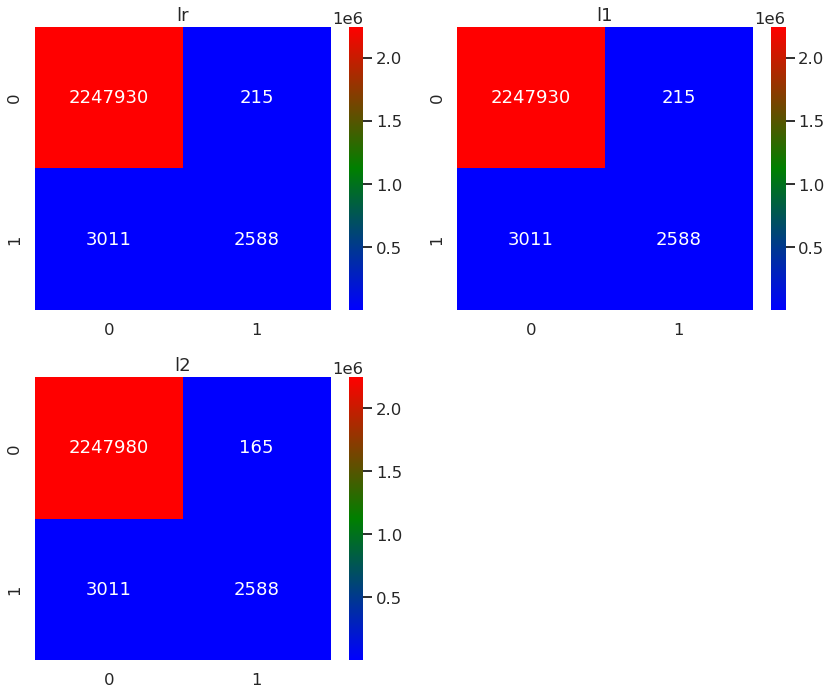

In [61]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d',cmap=cmap1);
    ax.set(title=lab);

plt.tight_layout()

**Conclusions**

The results (f-score = 0.99) show an extremely high accuracy and success of predicting bad receiver channels using instrumentation test feedback such as capacitance and leakage values and applying a logistic regression machine learning technique. This has important implications for identifying badly performing hydrophones both during a survey and afterwards in processing the seismic data.